In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Density map comparison between two directories

We first investigate 2 ground truth density folders. We find discrepancies for 2 files. We visualize the ground truth density maps from both folders below.

In [2]:
import os
err = 0
for file in os.listdir("../data/gt_density_map_adaptive_384_VarV2/"):
    dens_0 = np.load(f"../data/gt_density_map_adaptive_384_VarV2/{file}")
    dens_1 = np.load(f"../data/gt_density_map_special/{file}")
    
    diff = np.sum(np.abs(dens_0 - dens_1))
    if diff > 0:
        print(file)
    err += diff
    
print(err)

3471.npy
3477.npy
417.9150242960926


We see that the density map is more blurred in the second folder than in the first.

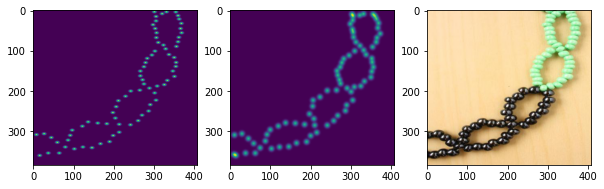

In [3]:
file_name = "3471.npy"
dens_0 = np.load(f"../data/gt_density_map_adaptive_384_VarV2/{file_name}")
dens_1 = np.load(f"../data/gt_density_map_special/{file_name}")
img = Image.open(f"../data/images_384_VarV2/{file_name.replace('.npy', '.jpg')}")

f, axarr = plt.subplots(1,3, figsize=(10, 10))
axarr[0].imshow(dens_0)
axarr[1].imshow(dens_1)
axarr[2].imshow(img)

We see that different elements are considered for counting from both images.

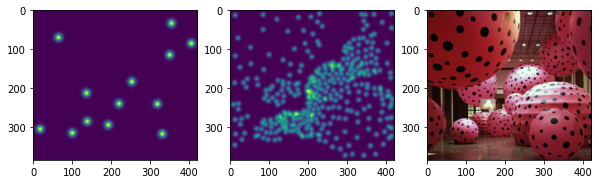

In [4]:
file_name = "3477.npy"
dens_0 = np.load(f"../data/gt_density_map_adaptive_384_VarV2/{file_name}")
dens_1 = np.load(f"../data/gt_density_map_special/{file_name}")
img = Image.open(f"../data/images_384_VarV2/{file_name.replace('.npy', '.jpg')}")

f, axarr = plt.subplots(1,3, figsize=(10, 10))
axarr[0].imshow(dens_0)
axarr[1].imshow(dens_1)
axarr[2].imshow(img)

## Re-generation of density maps

In [5]:
import scipy.spatial
import scipy.ndimage
import scipy.signal

Authors only provide the pre-computed density maps and describe the process in the paper. We try to replicate their results and verify that the pre-computed density maps are indeed corretly generated.

In [6]:
# Density map generator
# Borrowed and edited from https://github.com/davideverona/deep-crowd-counting_crowdnet
def generate_density_map(gt):
    
    # if count is 0 return empty density map
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))

    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    
    # query distances and keep only distances to neighbours (k = 1 is always 0)
    dists, _ = tree.query(pts, k = 2)
    
    avg = np.average(dists[:, 1])
    w = avg
    s = avg/4
    t = (((w - 1)/2)-0.5)/s

    density = scipy.ndimage.filters.gaussian_filter(gt, sigma=s, truncate=t)
    
    return density

In [7]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=2)

    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    return density

In [6]:
import numpy as np

def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [7]:
import json
import cv2
with open('../data/annotation_FSC147_384.json') as json_file:
    data = json.load(json_file)

In [8]:
file = "4"
data[f"{file}.jpg"]

{'H': 534,
 'W': 799,
 'box_examples_coordinates': [[[338, 158], [338, 183], [354, 183], [354, 158]],
  [[201, 210], [201, 225], [215, 225], [215, 210]],
  [[259, 45], [259, 73], [278, 73], [278, 45]]],
 'box_examples_path': ['/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/4_0.jpg',
  '/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/4_1.jpg'],
 'density_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_adaptive_384_VarV2/4.npy',
 'density_path_fixed': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_fixed/4.npy',
 'img_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/images_384_VarV2/4.jpg',
 'points': [[66.24374217772215, 197.09842696629212],
  [24.899874843554443, 140.66337078651685],
  [143.1023153942428, 156.95101123595504],
  [269.4511889862328, 56.29842696629214],
  [348.0585106382979, 167.42831460674157],
  [515.744055068836, 58.04584269662921],
  [282.84386733416767, 212.81078651685394],
  [209.47559449311638, 218.62831460674155],
  [192.00969962453067, 208.

In [9]:
ratio_h = data[f"{file}.jpg"]["ratio_h"]
ratio_w = data[f"{file}.jpg"]["ratio_w"]

In [37]:
66.24374217772215 / ratio_h

92.12020396589487

In [10]:
pts = np.array(data[f"{file}.jpg"]["points"])
pts[:, 0] /= ratio_w
pts[:, 1] /= ratio_h
pts

array([[ 92.05, 274.09],
       [ 34.6 , 195.61],
       [198.85, 218.26],
       [374.42,  78.29],
       [483.65, 232.83],
       [716.66,  80.72],
       [393.03, 295.94],
       [291.08, 304.03],
       [266.81, 290.27],
       [176.19, 297.55]])

In [11]:
#pts1 = np.round(data[f"{file}.jpg"]["points"]).astype(np.int32)
pts1 = np.array(data[f"{file}.jpg"]["points"])#.astype(np.int32)
pts1

array([[ 66.24374218, 197.09842697],
       [ 24.89987484, 140.66337079],
       [143.10231539, 156.95101124],
       [269.45118899,  56.29842697],
       [348.05851064, 167.42831461],
       [515.74405507,  58.0458427 ],
       [282.84386733, 212.81078652],
       [209.47559449, 218.62831461],
       [192.00969962, 208.73348315],
       [126.79505632, 213.96853933]])

In [250]:
data[f"{file}.jpg"]

{'H': 534,
 'W': 799,
 'box_examples_coordinates': [[[338, 158], [338, 183], [354, 183], [354, 158]],
  [[201, 210], [201, 225], [215, 225], [215, 210]],
  [[259, 45], [259, 73], [278, 73], [278, 45]]],
 'box_examples_path': ['/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/4_0.jpg',
  '/nfs/bigneuron/viresh/FSC_NewDataOnly/box_examples/4_1.jpg'],
 'density_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_adaptive_384_VarV2/4.npy',
 'density_path_fixed': '/nfs/bigneuron/viresh/FSC_NewDataOnly/gt_density_map_fixed/4.npy',
 'img_path': '/nfs/bigneuron/viresh/FSC_NewDataOnly/images_384_VarV2/4.jpg',
 'points': [[66.24374217772215, 197.09842696629212],
  [24.899874843554443, 140.66337078651685],
  [143.1023153942428, 156.95101123595504],
  [269.4511889862328, 56.29842696629214],
  [348.0585106382979, 167.42831460674157],
  [515.744055068836, 58.04584269662921],
  [282.84386733416767, 212.81078651685394],
  [209.47559449311638, 218.62831460674155],
  [192.00969962453067, 208.

In [251]:
tree = scipy.spatial.KDTree(pts1.copy(), leafsize=10)

In [252]:
dists, neighbours = tree.query(pts1, k = 2, p = 2)
print(dists)
print(neighbours)

[[  0.          62.85747637]
 [  0.          69.95878024]
 [  0.          59.30366943]
 [  0.         136.12113335]
 [  0.          79.45135907]
 [  0.         200.20730999]
 [  0.          73.59855361]
 [  0.          20.07399246]
 [  0.          20.07399246]
 [  0.          59.30366943]]
[[0 9]
 [1 0]
 [2 9]
 [3 4]
 [4 6]
 [5 4]
 [6 7]
 [7 8]
 [8 7]
 [9 2]]


In [253]:
avg = np.average(dists[:, 1])
avg

78.09499363929407

In [254]:
w = avg
s = avg/8
print(f"{w}, {s}")

78.09499363929407, 9.76187420491176


In [258]:
#test = np.zeros(gt_generated.shape)
test = np.zeros((384, 575))
for i in range(pts.shape[0]):
    y = int(pts1[i, 1])
    x = int(pts1[i, 0])
    test[y, x] = 1
    
#plt.figure(figsize=(10, 10))
#plt.imshow(test)

In [259]:
#import cv2
#k = cv2.getGaussianKernel(41, 10)
#filt1 = np.outer(k, k)
filt = matlab_style_gauss2D((w, w), s )

#np.sum(np.abs(filt1- filt))

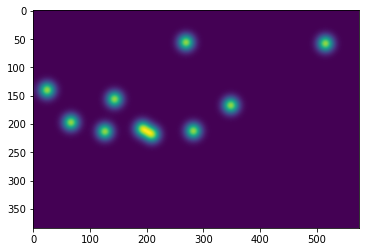

In [260]:
#pred = scipy.signal.convolve2d(test.copy(), filt, mode = "same")
pred = cv2.filter2D(test.copy(), -1, filt, 0)
plt.imshow(pred)

10.00183801008965
10.001839056724975


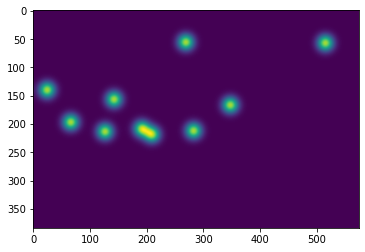

In [228]:
resized = cv2.resize(pred, (575, 384), interpolation = cv2.INTER_CUBIC)
resized = resized * (1 / ratio_w) * (1 / ratio_h)
plt.imshow(resized)
print(np.sum(resized))
print(np.sum(pred))

(384, 575)


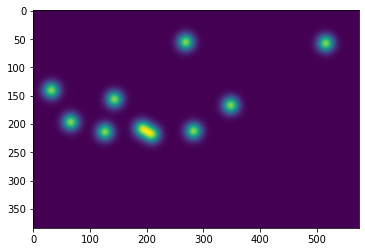

In [229]:
gt_generated = np.load(f"../data/gt_density_map_adaptive_384_VarV2/{file}.npy")

plt.imshow(gt_generated)
print(gt_generated.shape)

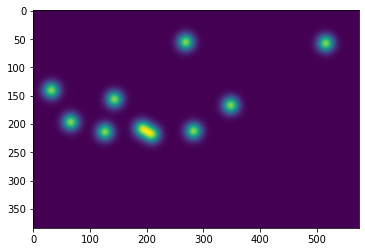

In [230]:
plt.imshow(gt_generated)

In [231]:
print(np.sum(resized))
print(np.sum(gt_generated))

10.00183801008965
9.999997


In [232]:
pred

array([[ 4.52327417e-21,  5.04658922e-21,  5.37434638e-21, ...,
        -1.18610194e-20, -1.21442478e-20, -1.24179482e-20],
       [-4.28184978e-21, -1.47665846e-21,  1.28310336e-21, ...,
        -7.78518815e-21, -6.81915401e-21, -5.86893639e-21],
       [-4.88515553e-20, -4.76530811e-20, -4.64535439e-20, ...,
        -8.66165583e-21, -9.22100811e-21, -9.76790163e-21],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [233]:
np.sum(np.abs(resized-gt_generated))

1.1180237065564205

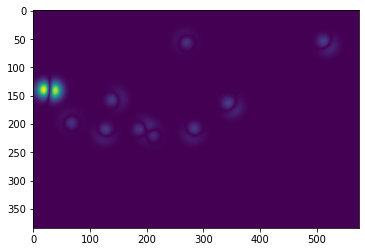

In [234]:
plt.imshow(np.abs(resized - gt_generated))

In [21]:
def generate_gt_density(pts, shape):
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=10)
    dists, _ = tree.query(pts, k = 2, p = 2)
    avg = np.average(dists[:, 1])
    s = avg/8
    
    pred = np.zeros(shape)
    for i in range(pts.shape[0]):
        y = int(pts[i, 1])
        x = int(pts[i, 0])
        pred[y, x] = 1
        
    filt = matlab_style_gauss2D((avg, avg), s)
    
    pred = cv2.filter2D(pred, -1, filt, 0)
    
    return pred

In [72]:
def generate_gt_density_and_resize(pts, shape, out_shape):
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=10)
    dists, _ = tree.query(pts, k = 2, p = 2)
    avg = np.average(dists[:, 1])
    s = avg/8
    
    pred = np.zeros(shape)
    for i in range(pts.shape[0]):
        y = int(pts[i, 1])
        x = int(pts[i, 0])
        pred[y, x] = 1
        
    filt = matlab_style_gauss2D((avg, avg), s)
    
    pred = cv2.filter2D(pred, -1, filt, 0)
    
    resized = cv2.resize(pred, out_shape, interpolation = cv2.INTER_LINEAR)
    resized = resized * (1 / ratio_w) * (1 / ratio_h)
    #resized = resized * (shape[0] / out_shape[1]) * (shape[1] / out_shape[0])
    
    return resized

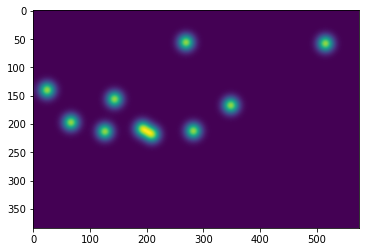

In [25]:
dens1 = generate_gt_density(pts1, (384, 575))
plt.imshow(dens1)

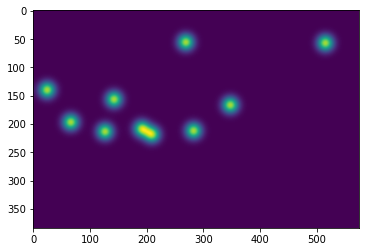

In [73]:
dens2 = generate_gt_density_and_resize(pts, (534, 799), (575, 384))
plt.imshow(dens2)

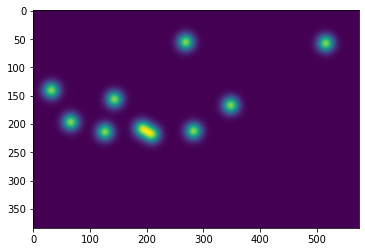

In [28]:
dens_gt = np.load(f"../data/gt_density_map_adaptive_384_VarV2/{file}.npy")
plt.imshow(dens_gt)

In [60]:
np.sum(np.abs(dens1 - dens2))

0.4868201874004124

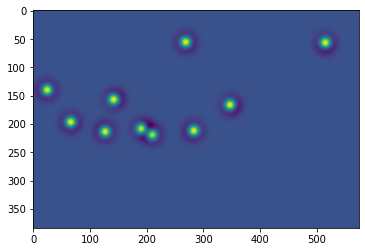

In [65]:
plt.imshow(dens2 - dens1)

In [74]:
np.sum(np.abs(dens2 - dens_gt))

1.111512752495817

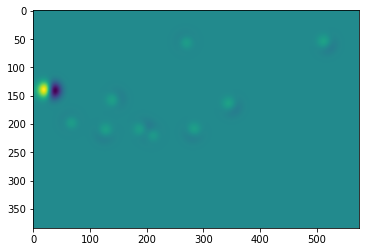

In [75]:
plt.imshow(dens2 - dens_gt)